In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop, Adam

## データの確認

In [4]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

display(df_train.head())
display(df_test.head())

id  Gender        Age    Height      Weight family_history_with_overweight  \
0   0    Male  24.443011  1.699998   81.669950                            yes   
1   1  Female  18.000000  1.560000   57.000000                            yes   
2   2  Female  18.000000  1.711460   50.165754                            yes   
3   3  Female  20.952737  1.710730  131.274851                            yes   
4   4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   
3  yes  3.000000  3.000000   Sometimes    no  1.674061  no  1.467863   
4  yes  2.679664  1.971472   Sometimes    no  1.979848  no  1.967973   

        TUE       CALC                 MTRANS           NObeyesdad  
0  0.976473  Sometimes  Public_Transportation  Overweight_Level_II  
1  1.000000         no             Automobile        Normal_Weight  
2  1.673584         no  Public_Transportation  Insufficient_Weight  
3  0.780199  Sometimes  Public_Transportation     Obesity_Type_III  
4  0.931721  Sometimes  Public_Transportation  Overweight_Level_II

id  Gender        Age    Height      Weight  \
0  20758    Male  26.899886  1.848294  120.644178   
1  20759  Female  21.000000  1.600000   66.000000   
2  20760  Female  26.000000  1.643355  111.600553   
3  20761    Male  20.979254  1.553127  103.669116   
4  20762  Female  26.000000  1.627396  104.835346   

  family_history_with_overweight FAVC      FCVC       NCP       CAEC SMOKE  \
0                            yes  yes  2.938616  3.000000  Sometimes    no   
1                            yes  yes  2.000000  1.000000  Sometimes    no   
2                            yes  yes  3.000000  3.000000  Sometimes    no   
3                            yes  yes  2.000000  2.977909  Sometimes    no   
4                            yes  yes  3.000000  3.000000  Sometimes    no   

       CH2O SCC       FAF       TUE       CALC                 MTRANS  
0  2.825629  no  0.855400  0.000000  Sometimes  Public_Transportation  
1  3.000000  no  1.000000  0.000000  Sometimes  Public_Transportation  
2  2.621877  no  0.000000  0.250502  Sometimes  Public_Transportation  
3  2.786417  no  0.094851  0.000000  Sometimes  Public_Transportation  
4  2.653531  no  0.000000  0.741069  Sometimes  Public_Transportation

In [5]:
print('Train: ')
print(df_train.isnull().sum())
print('\n')
print('Test: ')
print(df_test.isnull().sum())

Train: 
id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


Test: 
id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               

欠損値はない

In [6]:
print(df_train.info(),df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

## 数値データのカテゴリデータの分類

In [7]:
numerical_columns = df_train.select_dtypes(include=['float64', 'int64'])
object_columns = df_train.select_dtypes(include=['object'])

## カテゴリデータの前処理

In [8]:
def plot_category_distribution(data, category_field):
    """
    データフレームの指定されたカテゴリフィールドに基づいて円グラフと棒グラフを作成する関数。

    Parameters:
    - data: データフレーム
    - category_field: カテゴリフィールドの列名

    Returns:
    - None (グラフが表示されます)
    """

    # カテゴリごとのデータ数を取得
    category_counts = data[category_field].value_counts()

    # 円グラフの作成
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'{category_field} Distribution')

    # 棒グラフの作成
    plt.subplot(1, 2, 2)
    category_counts.plot(kind='bar', color='skyblue')
    plt.xlabel(category_field)
    plt.ylabel('Count')
    plt.title(f'{category_field} Counts')

    # グラフを表示
    plt.tight_layout()
    plt.show()

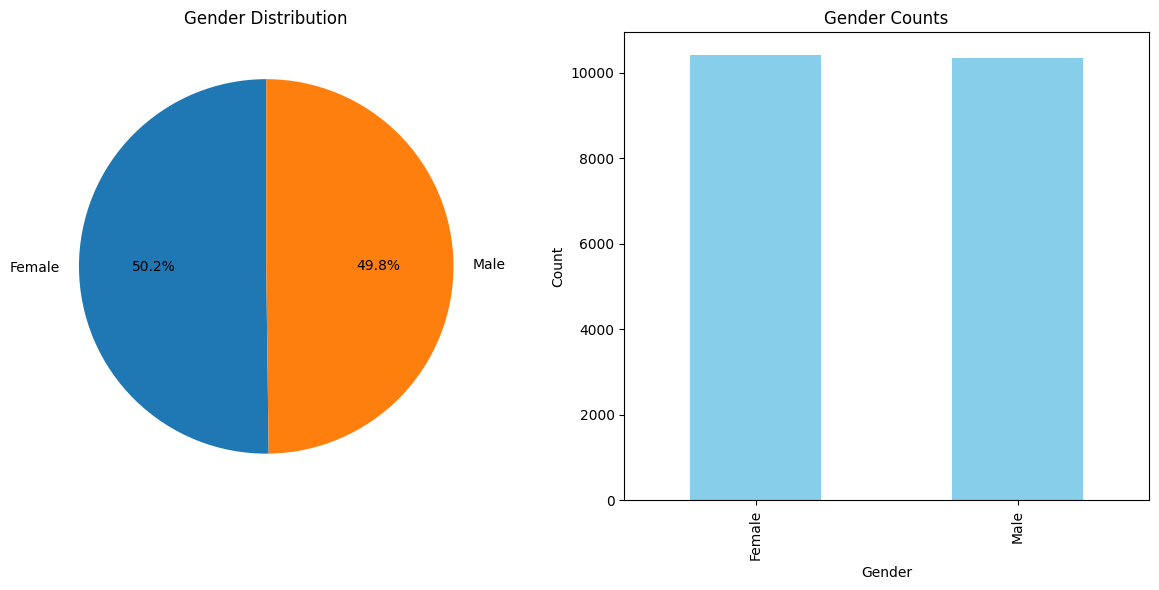

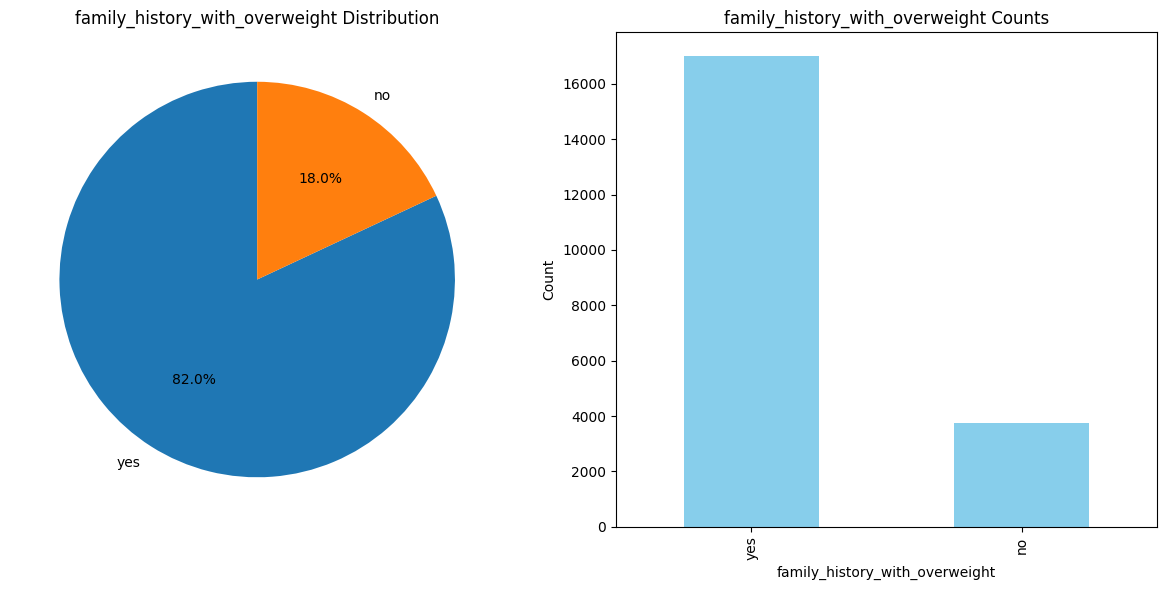

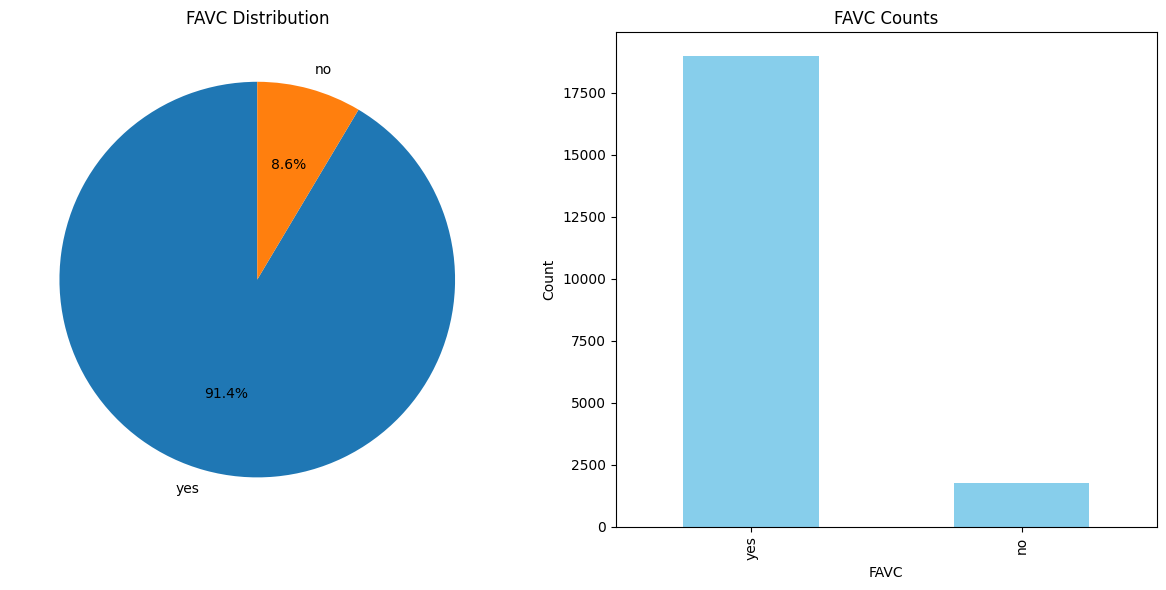

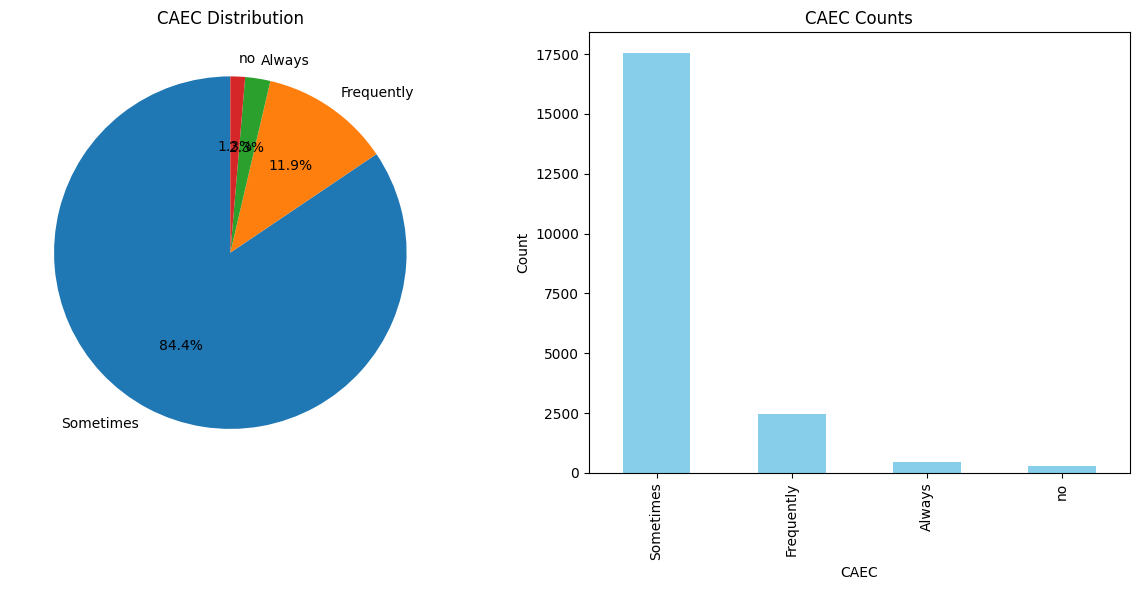

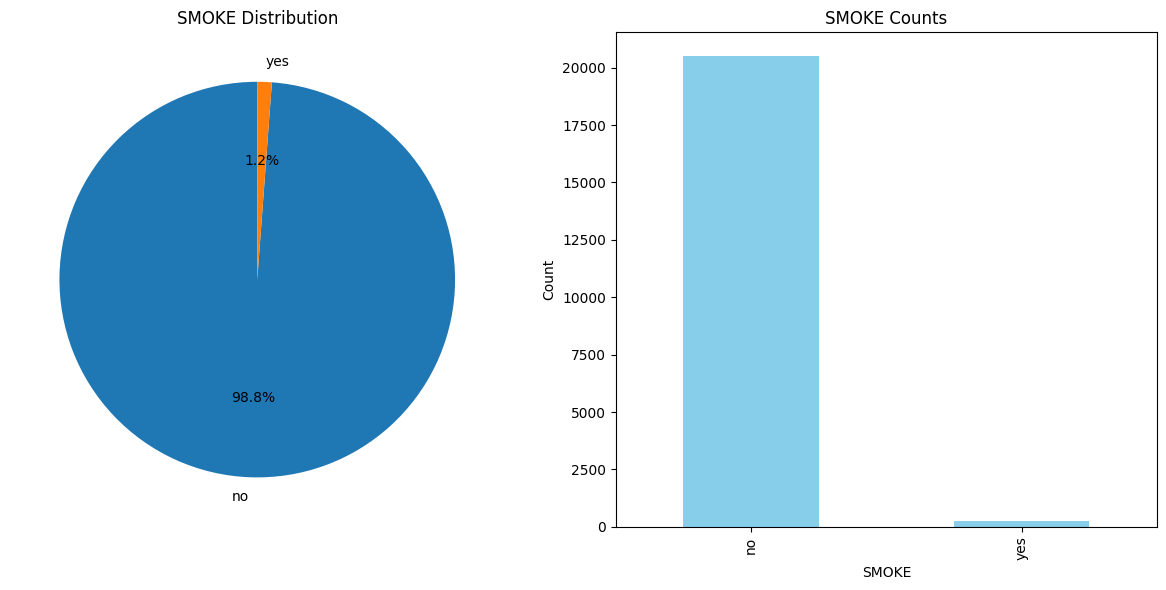

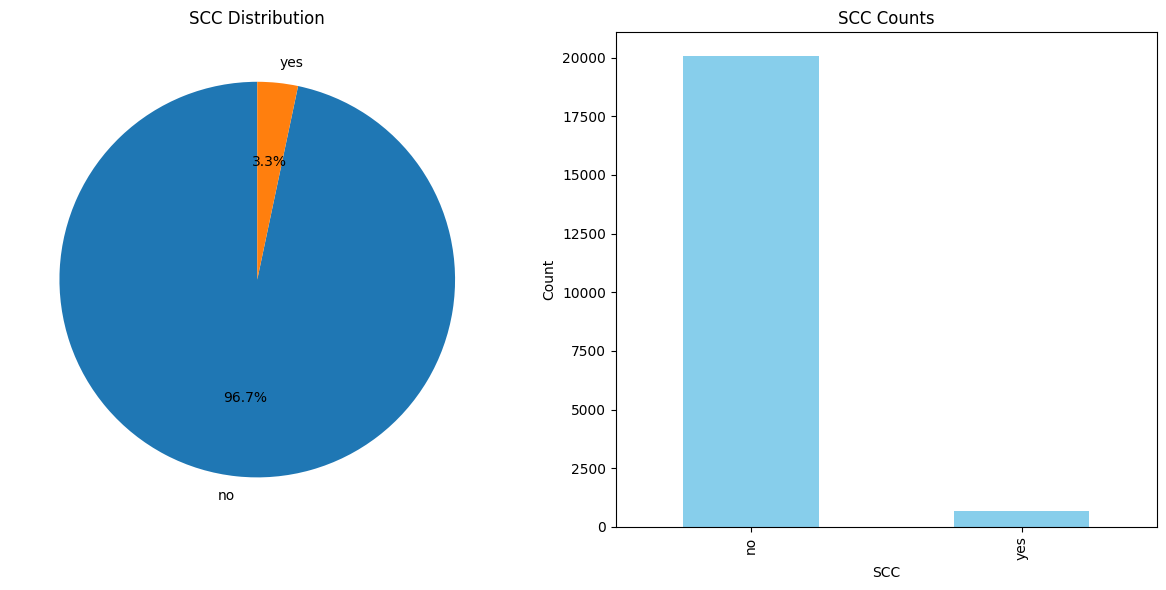

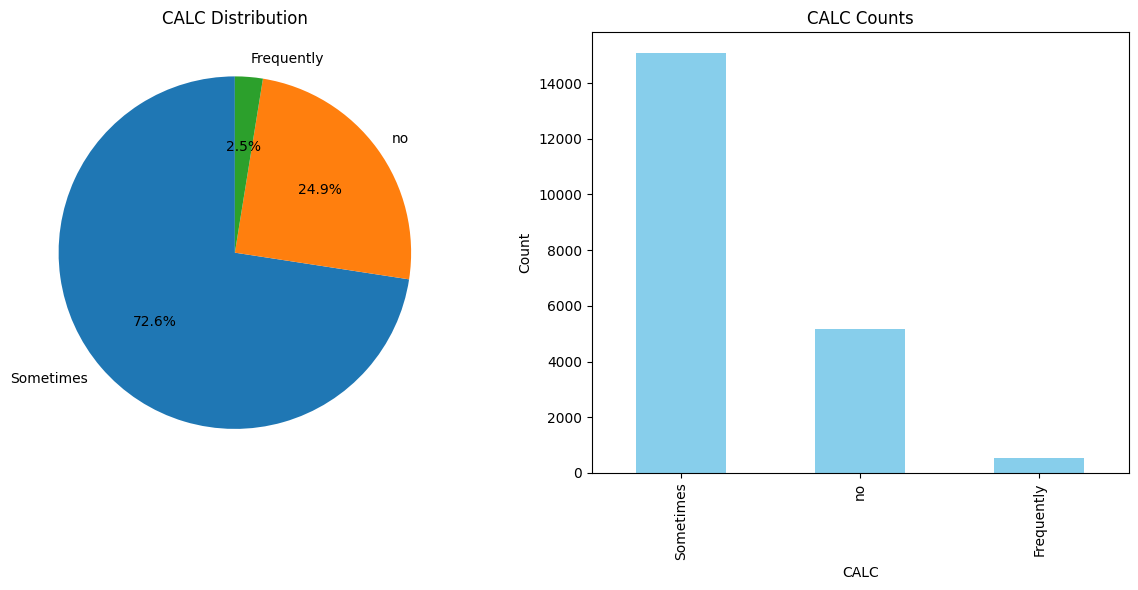

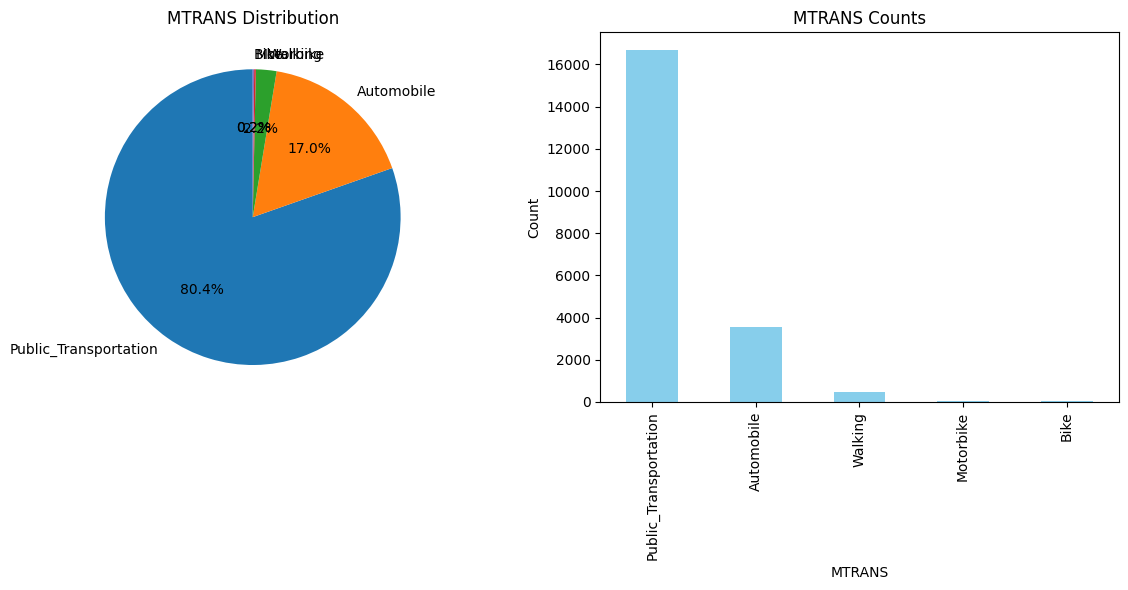

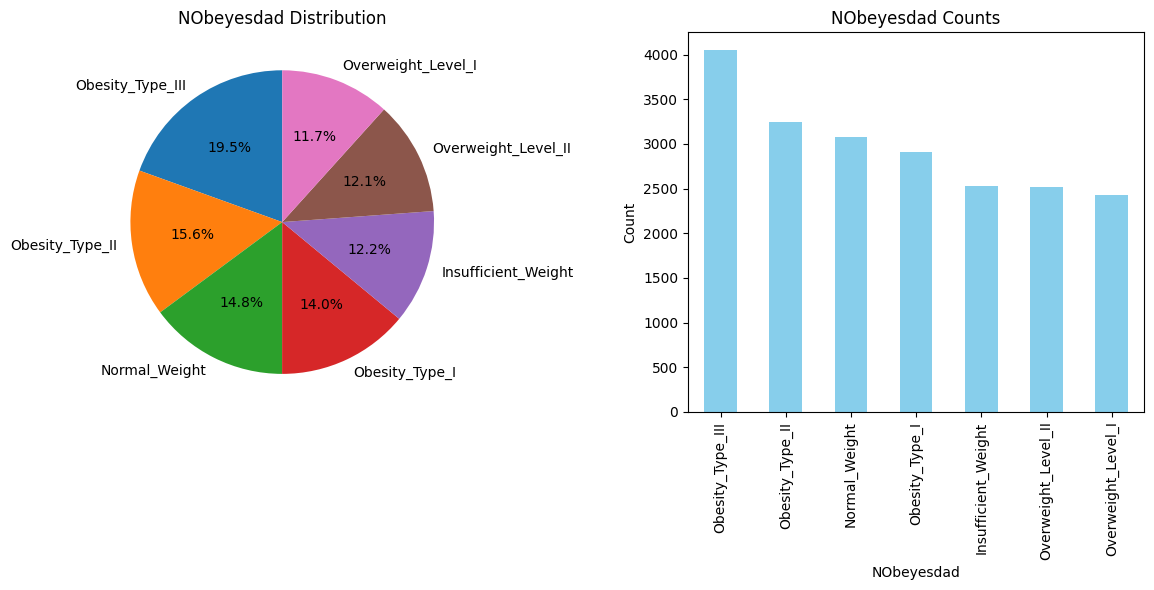

In [9]:
# 関数を呼び出してグラフを表示
for column in object_columns.columns:
    plot_category_distribution(object_columns, column)

### binary columnsのエンコーディング

In [10]:
binary_cols = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

for col in binary_cols:
    df_train[col] = df_train[col].map({'yes': 1, 'no': 0})
    
df_train['Gender'] = df_train['Gender'].map({'Male':1,'Female':0})
    
df_train.head()

id  Gender        Age    Height      Weight  \
0   0       1  24.443011  1.699998   81.669950   
1   1       0  18.000000  1.560000   57.000000   
2   2       0  18.000000  1.711460   50.165754   
3   3       0  20.952737  1.710730  131.274851   
4   4       1  31.641081  1.914186   93.798055   

   family_history_with_overweight  FAVC      FCVC       NCP        CAEC  \
0                               1     1  2.000000  2.983297   Sometimes   
1                               1     1  2.000000  3.000000  Frequently   
2                               1     1  1.880534  1.411685   Sometimes   
3                               1     1  3.000000  3.000000   Sometimes   
4                               1     1  2.679664  1.971472   Sometimes   

   SMOKE      CH2O  SCC       FAF       TUE       CALC                 MTRANS  \
0      0  2.763573    0  0.000000  0.976473  Sometimes  Public_Transportation   
1      0  2.000000    0  1.000000  1.000000         no             Automobile   
2      0  1.910378    0  0.866045  1.673584         no  Public_Transportation   
3      0  1.674061    0  1.467863  0.780199  Sometimes  Public_Transportation   
4      0  1.979848    0  1.967973  0.931721  Sometimes  Public_Transportation   

            NObeyesdad  
0  Overweight_Level_II  
1        Normal_Weight  
2  Insufficient_Weight  
3     Obesity_Type_III  
4  Overweight_Level_II

### 順番が関係するobject columnsのエンコーディング

In [11]:
df_train['CAEC'] = df_train['CAEC'].map({
    'no': 0,
    'Always': 3,
    'Frequently': 2,
    'Sometimes': 1
})

df_train['CALC'] = df_train['CALC'].map({
    'no': 0,
    'Frequently': 2,
    'Sometimes': 1
})

df_train[['CAEC', 'CALC']].head()

CAEC  CALC
0     1     1
1     2     0
2     1     0
3     1     1
4     1     1

### ラベルの重みを決定

In [12]:
transport_mapping = {
    'Bike': 2,
    'Walking': 2,
    'Public_Transportation': 1,
    'Automobile': 0,
    'Motorbike': 0,
}

df_train['MTRANS'] = df_train['MTRANS'].map(transport_mapping)

# Check the results
print(df_train['MTRANS'].value_counts())
df_train.head()

MTRANS
1    16687
0     3572
2      499
Name: count, dtype: int64


id  Gender        Age    Height      Weight  \
0   0       1  24.443011  1.699998   81.669950   
1   1       0  18.000000  1.560000   57.000000   
2   2       0  18.000000  1.711460   50.165754   
3   3       0  20.952737  1.710730  131.274851   
4   4       1  31.641081  1.914186   93.798055   

   family_history_with_overweight  FAVC      FCVC       NCP  CAEC  SMOKE  \
0                               1     1  2.000000  2.983297     1      0   
1                               1     1  2.000000  3.000000     2      0   
2                               1     1  1.880534  1.411685     1      0   
3                               1     1  3.000000  3.000000     1      0   
4                               1     1  2.679664  1.971472     1      0   

       CH2O  SCC       FAF       TUE  CALC  MTRANS           NObeyesdad  
0  2.763573    0  0.000000  0.976473     1       1  Overweight_Level_II  
1  2.000000    0  1.000000  1.000000     0       0        Normal_Weight  
2  1.910378    0  0.866045  1.673584     0       1  Insufficient_Weight  
3  1.674061    0  1.467863  0.780199     1       1     Obesity_Type_III  
4  1.979848    0  1.967973  0.931721     1       1  Overweight_Level_II

## 数値データの可視化

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

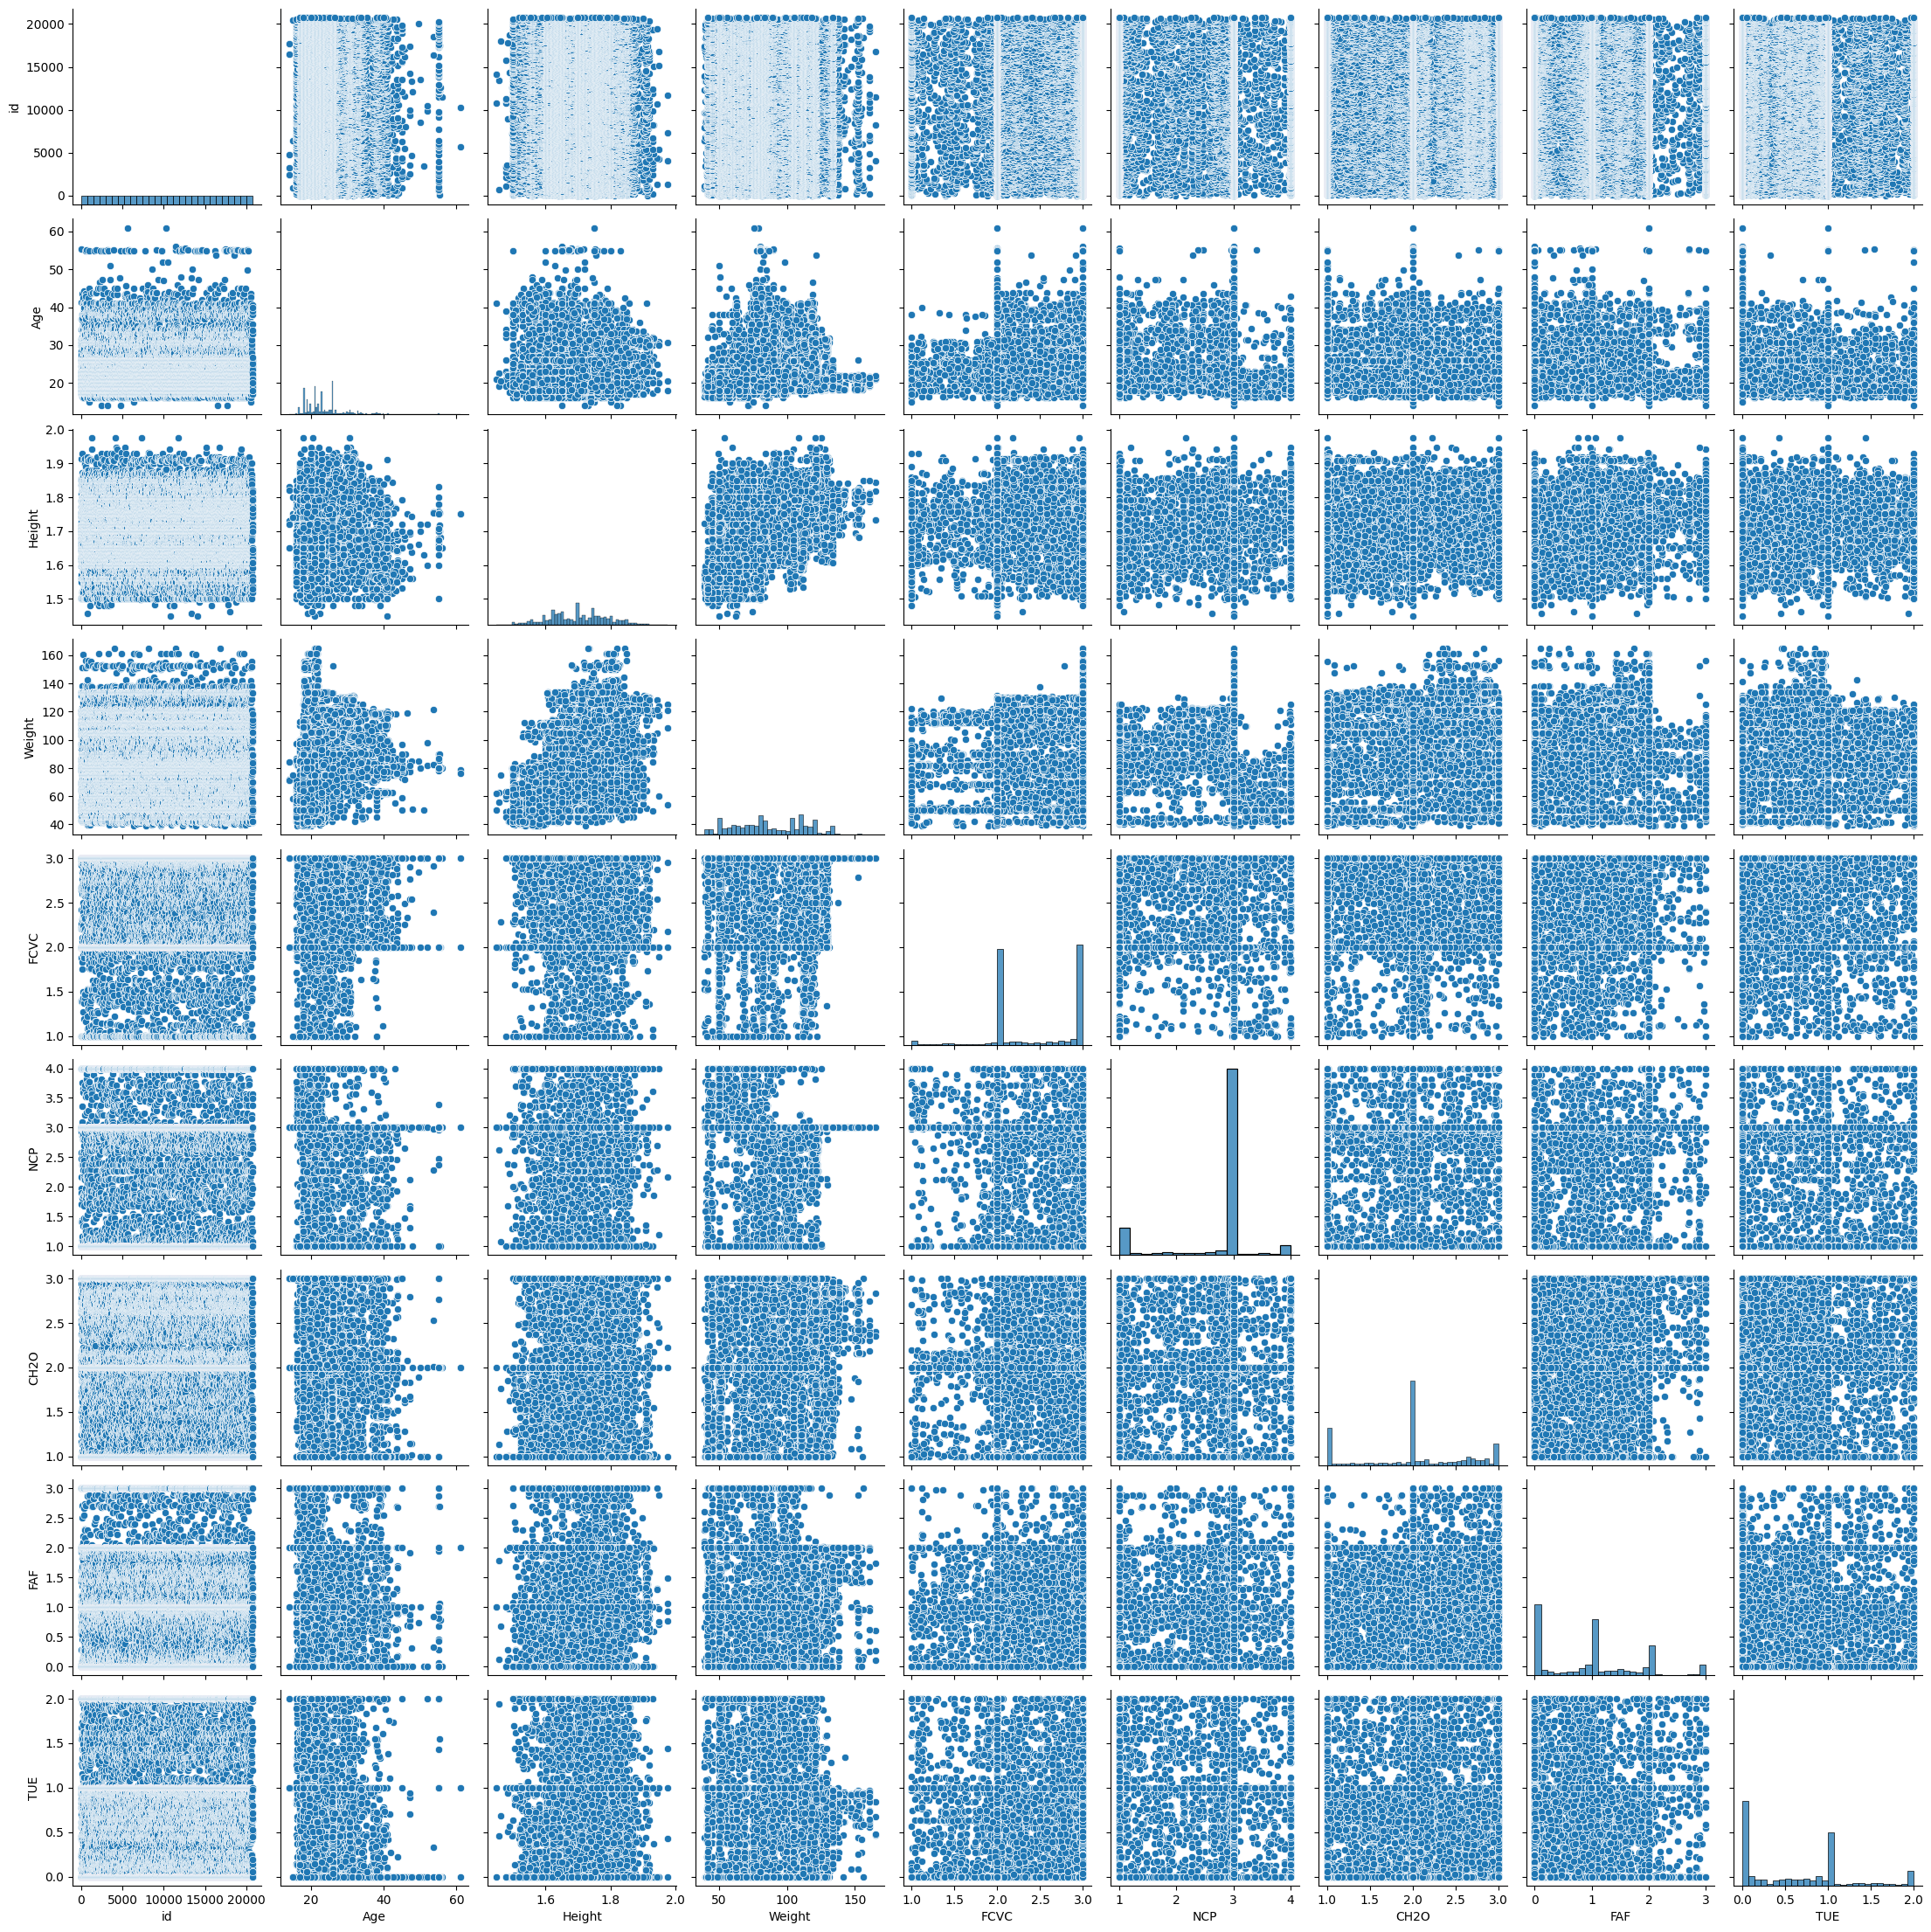

In [13]:
sns.pairplot(numerical_columns)
plt.show()

<Axes: >

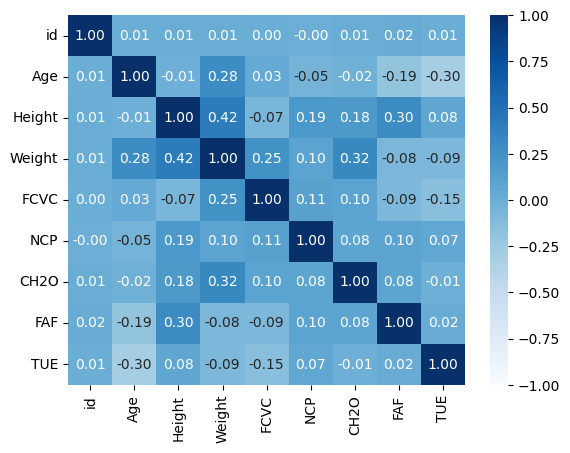

In [40]:
cor = numerical_columns.corr()
sns.heatmap(cor, cmap= 'Blues', annot=True,fmt='.2f', vmin = -1, vmax = 1)

In [26]:

def plot_numeric_fields(data):
    """
    データフレーム内の数値フィールドすべてに対してヒストグラムと密度関数を可視化する関数。

    Parameters:
    - data: データフレーム

    Returns:
    - None (グラフが表示されます)
    """

    # データフレームから数値フィールドを取得
    numeric_fields = data.columns
    plt.figure(figsize=(12, 6))

    # ヒストグラムと密度関数の描画
    for i , field in enumerate(numeric_fields):
    
        # ヒストグラム　Kernel密度関数
        plt.subplot(3, 4, i+1)
        sns.histplot(data[field], kde=True, bins=20)
        plt.title(f'{field} Histogram')

        # グラフを表示
        plt.tight_layout()
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

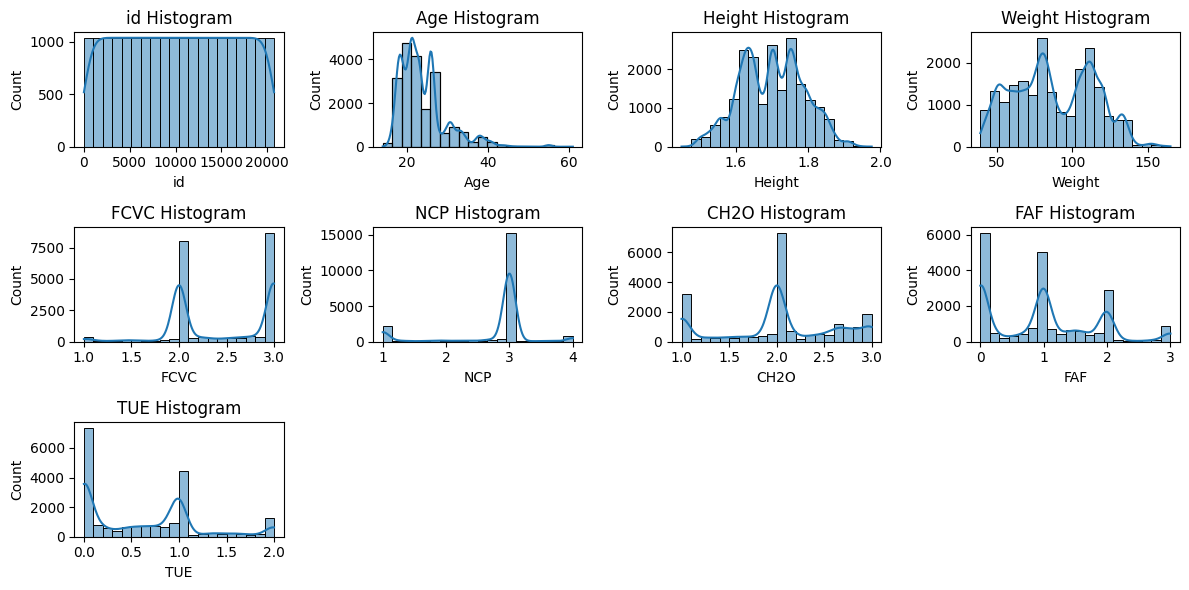

In [27]:
plot_numeric_fields(numerical_columns)

## 特徴量エンジニアリング
ここではBMI $$ BMI = \frac{Weight}{Height^2} $$で定義されるBMIを特徴量として追加する。

In [29]:
df_train['BMI'] = df_train['Weight'] / df_train['Height']**2
df_train[['Weight', 'Height', 'BMI']].head()

Weight    Height        BMI
0   81.669950  1.699998  28.259565
1   57.000000  1.560000  23.422091
2   50.165754  1.711460  17.126706
3  131.274851  1.710730  44.855798
4   93.798055  1.914186  25.599151

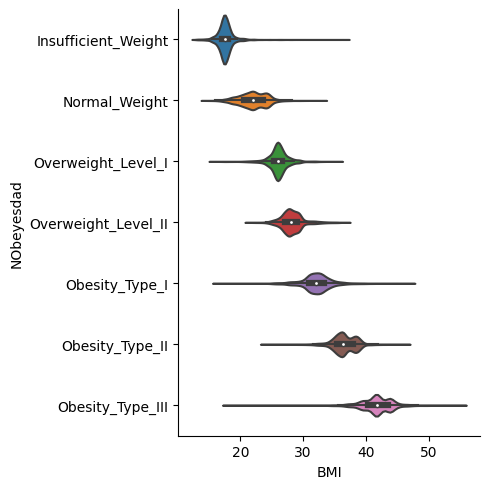

In [36]:
order = df_train.groupby('NObeyesdad')['BMI'].mean().sort_values().index
sns.catplot(x='BMI', y='NObeyesdad', data=df_train, kind='violin', order=order)
plt.show()